# Étape 1: Importation des librairies

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage


# Étape 2: Chargement des données

In [2]:
import pyodbc
from sklearn.preprocessing import LabelEncoder
# Paramètres de connexion à la base de données
server = 'DESKTOP-O7CGU5J\MSSQLSERVER2'
database = 'DW_HR_Projrct'
username = 'sa1'
password = 'sa@123@123'
driver = '{ODBC Driver 17 for SQL Server}'

# Chaîne de connexion
conn_str = f'DRIVER={driver};SERVER={server};DATABASE={database};UID={username};PWD={password}'

# Connectez-vous à la base de données
conn = pyodbc.connect(conn_str)

# Exécutez une requête SQL pour charger les données
sql_query = """
SELECT *
FROM dim_coursera
"""
coursera_data = pd.read_sql(sql_query, conn)

# Assurez-vous de fermer la connexion après les opérations
conn.close()




C:\Users\khiar\Anaconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


# Étape 3: Prétraitement des données

In [3]:
# Supprimer les valeurs manquantes ou les remplacer
coursera_data = coursera_data.dropna(subset=['Organization', 'Difficulty_Level','Price'])

# Encodage des variables catégorielles
label_enc_org = LabelEncoder()
label_enc_diff = LabelEncoder()
label_enc_name = LabelEncoder()
label_enc_src = LabelEncoder()
coursera_data['Organization_encoded'] = label_enc_org.fit_transform(coursera_data['Organization'])
coursera_data['Difficulty_Level_encoded'] = label_enc_diff.fit_transform(coursera_data['Difficulty_Level'])
coursera_data['course_Name_encoded'] = label_enc_name.fit_transform(coursera_data['course_Name'])
coursera_data['src_encoded'] = label_enc_src.fit_transform(coursera_data['src'])


# Normalisation des données
scaler = StandardScaler()
features = coursera_data[['course_Name_encoded','Organization_encoded', 'Difficulty_Level_encoded', 'Price', 'src_encoded']]
features_scaled = scaler.fit_transform(features)


# Étape 4: Application de K-means

In [4]:
# Définir le nombre de clusters
n_clusters = 3  # Exemple, à ajuster selon votre analyse

# Appliquer K-means
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
coursera_data['cluster_kmeans'] = kmeans.fit_predict(features_scaled)

# Afficher les centres des clusters
print(kmeans.cluster_centers_)

[[-0.22807597 -0.17573265  2.38622065  0.17153135 -0.22484688]
 [ 0.04990762 -0.00785802 -0.32578826 -0.07458953 -0.22484688]
 [-0.26441539  0.5919056  -0.60713144  0.83546665  4.44747119]]


# Étape 5: Application de CAH

In [32]:
# Appliquer l'algorithme de Clustering Hiérarchique Agglomératif
cah = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
coursera_data['cluster_cah'] = cah.fit_predict(features_scaled)

# Étape 6: Visualisation des résultats

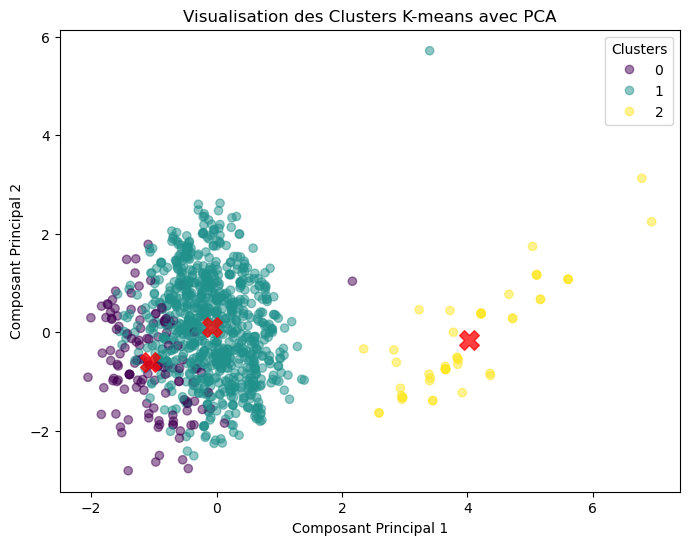

In [5]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Appliquer PCA pour réduire à deux dimensions pour la visualisation
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

# Ajouter les composants principaux comme nouvelles colonnes pour la visualisation
coursera_data['PCA1'] = features_pca[:, 0]
coursera_data['PCA2'] = features_pca[:, 1]

# Créer un graphique à dispersion
plt.figure(figsize=(8, 6))
scatter = plt.scatter(coursera_data['PCA1'], coursera_data['PCA2'], c=coursera_data['cluster_kmeans'], cmap='viridis', alpha=0.5)
plt.title('Visualisation des Clusters K-means avec PCA')
plt.xlabel('Composant Principal 1')
plt.ylabel('Composant Principal 2')

# Ajouter une légende pour les clusters
plt.legend(*scatter.legend_elements(), title='Clusters')

# Afficher les centres des clusters sur le graphique
centers = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='X')

plt.show()


Interprétation: 
Les graphiques montrent une bonne séparation du cluster jaune, qui peut représenter des cours distincts par le prix ou la difficulté. Les clusters violets et turquoises sont mélangés, suggérant une similarité dans les noms des cours, les organisations ou les sources. Cette disposition cohérente entre les ensembles d'entraînement et de test indique des patterns stables identifiés par le clustering K-means dans ces caractéristiques.

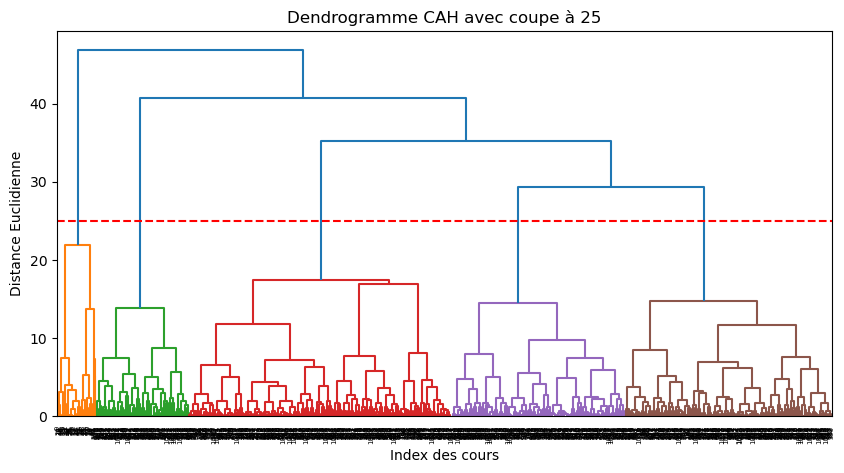

In [36]:



# Visualisation du dendrogramme pour le CAH avec une coupe à hauteur de 25
plt.figure(figsize=(10, 5))
Z = linkage(features_scaled, method='ward')
dendrogram(Z, color_threshold=25)  # La hauteur de coupe est spécifiée ici
plt.title('Dendrogramme CAH avec coupe à 25')
plt.xlabel('Index des cours')
plt.ylabel('Distance Euclidienne')
plt.axhline(y=25, color='r', linestyle='--')  # Ligne de coupe
plt.show()


Interprétation :

Le dendrogramme indique que couper à une hauteur de 25 divise les données en 5 clusters principaux diferrente de nbr de k-means, suggérant que c'est un mauvais choix pour le nombre de clusters à utiliser. La couleur différente des liens montre les groupements de cours à différents niveaux de similarité, 